#SCC - 275 CIENCIA DE DADOS
##PROFa. Roseli A F Romero
####PAE: Guilherme Nardari
#####2o. semestre de 2020

# Trabalho Final
## Análise dos novos casos semanais de COVID-19 em relação à Taxa de Isolamento Social no Estado de São Paulo
### Alunos:

- Eduardo Amaral - 11735021
- Vivian Kiyomi Amano - 11300502

## Sobre os dados
 
 Dados sobre o número de casos confirmados de COVID-19 e sobre a taxa de Isolamento Social no estado de São Paulo.

 Os dados referentes aos casos de COVID-19 foram coletados no OpenDataSUS através da API ElasticSearch presente em
 https://opendatasus.saude.gov.br/dataset/casos-nacionais

 Os dados referentes à Taxa de Isolamento Social foram coletados através do porta do estado de São Paulo presente em
 https://www.saopaulo.sp.gov.br/coronavirus/isolamento/

  Os dados foram capturados e pré-processados através de um script feito pelos alunos em Node.js presente em 
  https://github.com/rolimans/covidCasesAndDistancingRate

 As colunas de dados são:
 - averageAge (média de idade dos infectados na semana)
 - mostInfectedSex (sexo mais infectado na semana | F - Feminino, M - Masculino, E - igual)
 - weekDayWithMostCases (dia da semana com mais infecções | 0-6 Domingo-Sábado)
 - mostCommonTest (tipo de teste mais utilizado na semana)
 - daysSinceFirstCase (dias desde a primeira infecção)
 - percentageInfected (porcentagem da população infectada na semana)
 - percentageInfectedLastWeek (porcentagem da população infectada na semana passada)
 - newCases (número de casos novos na semana)
 - lastWeekCases (número de casos novos da semana passada)
 - averageDistancingRate (média de distanciamento social na semana)
 - averageDistancingRate1 (média de distanciamento social na semana anterior)
 - averageDistancingRate2 (média de distanciamento social duas semanas atrás)
 - averageDistancingRate3 (média de distanciamento social três semanas atrás)
 - distancingRateDifferrence1 (averageDistancingRate1 - averageDistancingRate2)
 - distancingRateDifferrence2 ((averageDistancingRate1 - averageDistancingRate2) + (averageDistancingRate1 - averageDistancingRate3) ) / 2
 - growthFactor (newCases / lastWeekCases )
 - growthFactorIncreased ( growthFactor >= 1.1 ) <--- ALVO
 - city (cidade dos casos)
 - weekOfYear (número da semana do ano)


Header em que as dependências são importadas e as funções de classificação são declaradas

In [ ]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import random

from google.colab import drive

from numpy import mean, std

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.neural_network import MLPClassifier

from scipy.ndimage.interpolation import shift

def teste(X,y):
  classificadores = {
    "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},  
  }

  scaler = MinMaxScaler()  # Normaliza-se os dados para testaem mais rápida
  scaler.fit(X)

  X = scaler.transform(X)

  for classificador_name in classificadores:  
    modelo = classificadores[classificador_name]["modelo"]
    classificadores[classificador_name]["scores"] = cross_val_score(modelo, X, y, cv=10)
    print("%s: %.2f " % (classificador_name, 100*np.mean(classificadores[classificador_name]["scores"])))



classificadores = {
  "Perceptron" : {"modelo": Perceptron(), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "SVM Polinomial Grau 3" : {"modelo": SVC(kernel='poly', degree=3, gamma=1), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},  
  "KNN k=5" : {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []},
}


def plot_roc(classifier, X, y):
  cv = StratifiedKFold(n_splits=10)  

  if isinstance(X, pd.core.frame.DataFrame):
    X = X.values
  if isinstance(y, pd.core.frame.DataFrame) or isinstance(y, pd.core.series.Series):
    y = y.values

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  fig.set_figwidth(15)
  fig.set_figheight(15)
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = plot_roc_curve(classifier, X[test], y[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)  

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example")
  ax.legend(loc="lower right")
  plt.show()


def classificacao_bootstrap(data, columns, target, score=balanced_accuracy_score, no_bs=1000, p_teste=0.2, score_name='acurácia', plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    no_bs:      Número de repetições do bootstrap
    p_teste:    Porcentagem para teste da amostra do bootstrap
    score_name: String. Uma string com o nome da medida de desempenho    
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados, medidas de desempenho e matriz de confusão
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000)
    
    clfs = [prcp, svm_n, dt, mlp, _5nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', 'mlp', '5nn']
    confusion_matrices = {
        'perceptron':np.array([[0,0],[0,0]]),
        'svm_poly':np.array([[0,0],[0,0]]),
        'dt':np.array([[0,0],[0,0]]),
        'mlp':np.array([[0,0],[0,0]]),
        '5nn':np.array([[0,0],[0,0]]),
    }
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], 'mlp':[], '5nn':[]}
    for c, c_name in zip(clfs, clfs_names):
      for i in range(0, no_bs):
        ################# IMPLEMENTE ABAIXO O BOOTSTRAP #######################
        #    Sua implementação deve fazer o append no vetor results da mesma 
        #    forma que a implementação original faz.
        #    Dentro desse loop:
        #     c: variável-objeto que representa o classificador
        #     c_name: Nome do classificador
        #     results: vetor de resultado
        #######################################################################
        amostra = data.sample(n = data.shape[0], replace=True)

        X = amostra.iloc[:, columns] # Separando em dados 
        y = amostra.iloc[:, target]  # e variável alvo
      
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste) # Split dos dados de maneira estratificada (mantendo prop. das classes)
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        
        data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= columns + ['target']) # Criando um dataframe com os dados de treino
        classe_0 = data_train[data_train['target'] == 0]
        classe_1 = data_train[data_train['target'] == 1]
        n_elementos_classe_0 = data_train['target'].value_counts()[0] # Coletando o número de exemplos da classe 0 para superamostragem da classe 1  
        data_train = pd.concat([classe_0, classe_1.sample(n=n_elementos_classe_0, replace=True)]) # Superamostragem da classe 1 para numero de elementos da classe 0

        X_train, y_train = data_train.iloc[:, columns], data_train.iloc[:, target] # reatribuição dos dados pra treino (agora superamostrados)
        
        # faz o treino do modelo
        clf = c.fit(X=X_train, y=y_train)
        
        # valores predito pelo classificador
        y_pred = clf.predict(X_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
        # realiza predição no conjunto de teste e salva o resultado
        results[c_name].append( score(y_test, y_pred) )
        confusion_matrices[c_name] += confusion_matrix(y_test, y_pred)      


        #######################################################################
        
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs, 'confusion_matrices': confusion_matrices}


def classificacao(data, columns, target, score=balanced_accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados, as medidas de desempenho e matriz de confusão
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000)
    
    clfs = [prcp, svm_n, dt, mlp, _5nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', 'mlp', '5nn']
    
    #Inicializa estruturas para matrizes de confusão 
    confusion_matrices = {
        'perceptron':np.array([[0,0],[0,0]]),
        'svm_poly':np.array([[0,0],[0,0]]),
        'dt':np.array([[0,0],[0,0]]),
        'mlp':np.array([[0,0],[0,0]]),
        '5nn':np.array([[0,0],[0,0]]),
    }

    # prepara validação cruzada
    # faz divisão do dataset em fold partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], 'mlp':[], '5nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
            confusion_matrices[c_name] += confusion_matrix(y_test, y_pred)        
    
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs, 'confusion_matrices': confusion_matrices}


In [ ]:
# Monta-se o Google Drive para acesso da base de dados
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cria-se o dataFrame através da base de dados em JSON

dF = pd.read_json('/content/drive/My Drive/Introdução à Ciência de Dados/Trabalho Final/database.json')
dF

,averageAge,mostInfectedSex,weekDayWithMostCases,mostCommonTest,daysSinceFirstCase,lastWeekCases,growthFactor,growthFactorIncreased,percentageInfected,percentageInfectedLastWeek,newCases,weekOfYear,city,averageDistancingRate,averageDistancingRate1,averageDistancingRate2,distancingRateDifference1,averageDistancingRate3,distancingRateDifference2
0,41,E,3,TESTE RÁPIDO - ANTÍGENO,4,NaN,NaN,None,0.000007,NaN,5,1,Santo André,NaN,NaN,NaN,NaN,NaN,NaN
1,70,M,0,TESTE RÁPIDO - ANTICORPO,11,5.0,0.200000,N,0.000008,0.000007,1,2,Santo André,NaN,NaN,NaN,NaN,NaN,NaN
2,38,M,0,RT-PCR,21,1.0,2.000000,Y,0.000011,0.000008,2,3,Santo André,NaN,NaN,NaN,NaN,NaN,NaN
3,28,F,3,RT-PCR,31,2.0,5.500000,Y,0.000026,0.000011,11,4,Santo André,NaN,NaN,NaN,NaN,NaN,NaN
4,44,M,6,TESTE RÁPIDO - ANTICORPO,32,11.0,0.272727,N,0.000030,0.000026,3,5,Santo André,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,41,M,3,TESTE RÁPIDO - ANTICORPO,304,94.0,0.914894,N,0.023869,0.022916,86,44,São Sebastião,0.538571,0.520000,0.524286,-0.004286,0.521429,-0.002857
3884,44,F,6,RT-PCR,311,86.0,0.709302,N,0.024544,0.023869,61,45,São Sebastião,0.525714,0.538571,0.520000,0.018571,0.524286,0.016429
3885,39,F,3,RT-PCR,318,61.0,0.934426,N,0.025175,0.024544,57,46,São Sebastião,0.518571,0.525714,0.538571,-0.012857,0.520000,-0.003571
3886,41,F,2,TESTE RÁPIDO - ANTICORPO,325,57.0,0.578947,N,0.025540,0.025175,33,47,São Sebastião,0.527143,0.518571,0.525714,-0.007143,0.538571,-0.013571


#Análise Visual

Realiza-se uma análise inicial dos dados visualmente a fim de mostrar pontos interessante da base de dados.

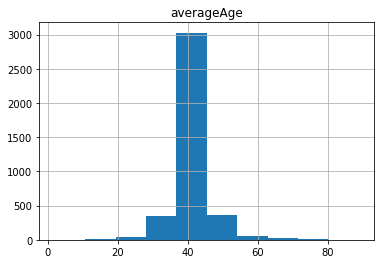

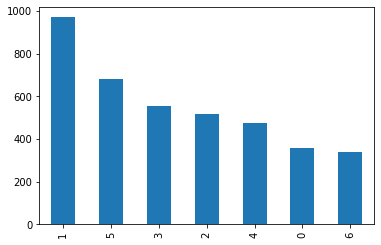

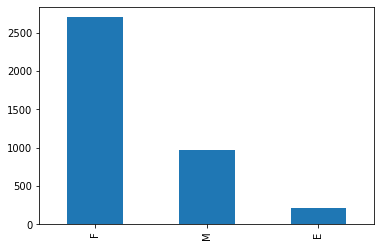

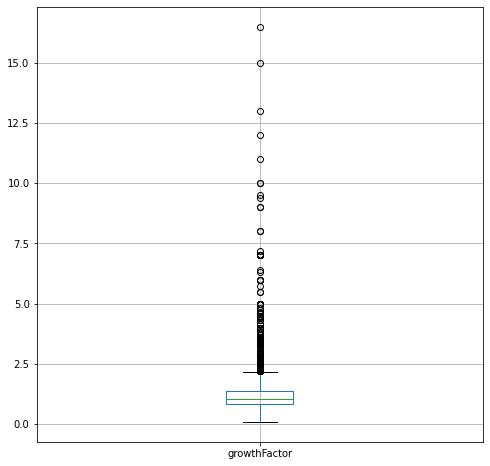

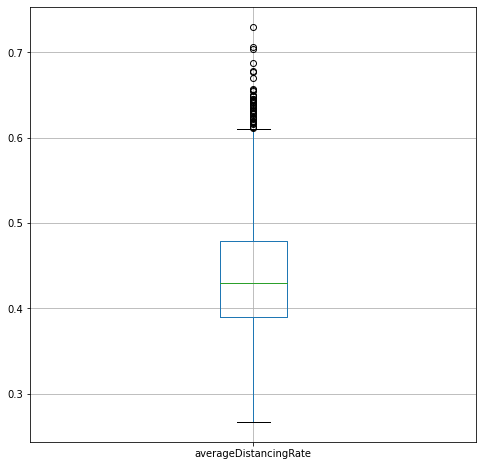

In [ ]:
dF.hist(column='averageAge') # Esperado
plt.show()
dF['weekDayWithMostCases'].value_counts().plot.bar()
plt.show()
dF['mostInfectedSex'].value_counts().plot.bar()
plt.show()
plt.figure(figsize=(8,8))
dF.boxplot(column='growthFactor')
plt.show()
plt.figure(figsize=(8,8))
dF.boxplot(column='averageDistancingRate')
plt.show()

Exemplifica-se o potencial da base de dados para análise visual através de um gráfico que tenta correlacionar a taxa de isolamento semanal com o número de novos casos.

Como presume-se que o efeito do isolamento não é imediato realiza-se difersos *shifts* na taxa de isolamento. Ou seja compara-se o número de casos novos com a taxa de isolamento de 0, 1, 2, 3, e 4 semanas atrás.

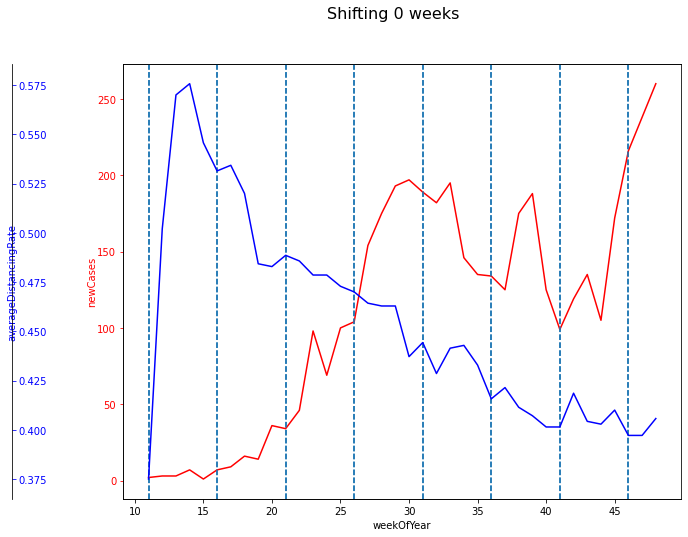

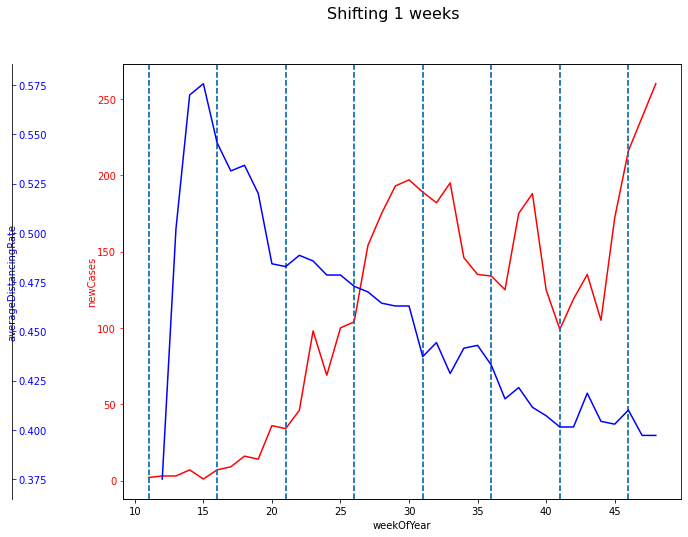

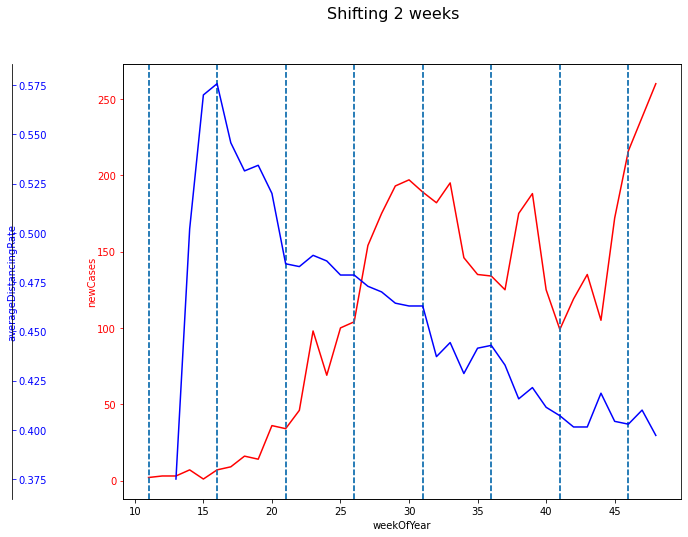

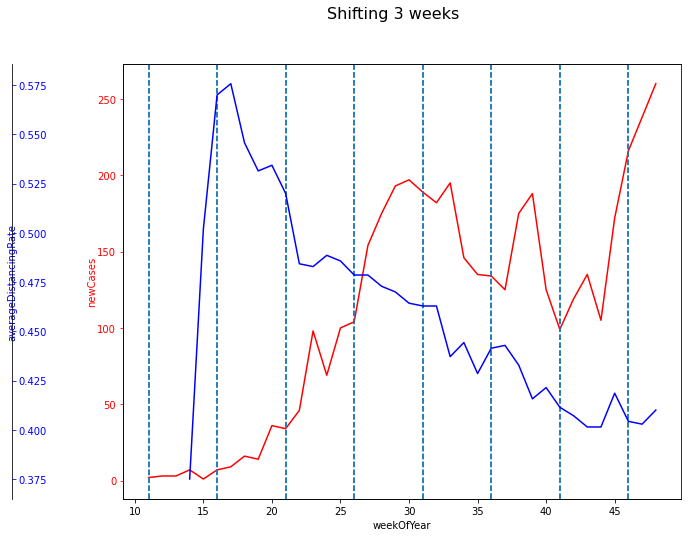

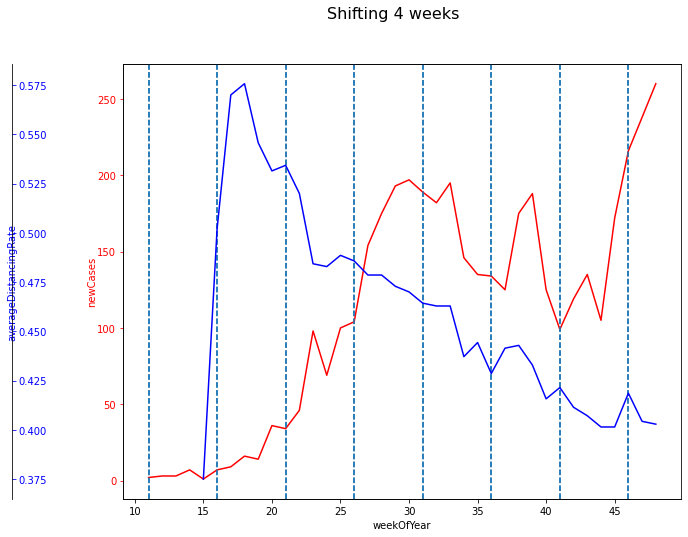

In [ ]:
cidade = "São Carlos"
# Seleciona-se a cidade a ser analisada

data = dF[(dF['city']==cidade) & (dF['weekOfYear'] >=10)]

for i in range(0,5):
  fig, ax = plt.subplots()
  fig.set_figwidth(10)
  fig.set_figheight(8)
  fig.suptitle('Shifting %s weeks' % i, fontsize=16)

  axes = [ax, ax.twinx()]
  axes[1].spines['right'].set_position(('axes', -0.2))
  axes[-1].set_frame_on(True)
  axes[-1].patch.set_visible(False)

  yAxes = ('newCases', 'averageDistancingRate')
  colors = ('Red', 'Blue')
  intAxNo = 0
  for ax, color, yAx in zip(axes, colors, yAxes):
      intAxNo += 1
      currData = data[yAx]
      if yAx == 'averageDistancingRate':
        currData = shift(currData, i, cval=np.NaN)
      xIndexes = np.array(data['weekOfYear'])
      for xI in range(0,len(xIndexes), 5):
        ax.axvline(x=xIndexes[xI], linestyle='--')
      ax.plot(xIndexes,currData, color=color)
      if (intAxNo > 1):
          if (intAxNo == 2):
              ax.set_ylabel('%s' % yAx, color=color, labelpad = -40 )
          ax.get_yaxis().set_tick_params(direction='out')
      else:
          ax.set_ylabel('%s' % yAx, color=color, labelpad = +0 )

      ax.tick_params(axis='y', colors=color)
  axes[0].set_xlabel('weekOfYear')


  plt.show()


#Pré-Processamento:
Inicia-se o pré-processamento de dados selecionando-se as variáveis plausíveis de serem mantidas para o algoritmo de classificação.

Logo, são excluídas aquelas variáveis que vazariam informações diretas sobre o *alvo*, como por exemplo: growthFactor (basicamente o que se quer analisar), newCases, mostCommonTest, averageDistancingRate (variáveis indisponíveis levando em conta que os dados presentes seriam apenas os de semanas anteriores à semana da análise), entre outras.

Remove-se também dados prévios à semana 10, pois os dados referentes ao isolamento social só estão disponíveis a partir do dia 05/03/2020 (semana 10).

Em um segundo momento substitui-se valores faltantes pela média/moda das colunas, padroniza-se os dados e transforma-se as variáveis categóricas em numéricas.

Transforma-se o alvo de Y/N para 1/0

In [ ]:
plausibleVariables = ['growthFactorIncreased','percentageInfectedLastWeek', 'weekOfYear', 'daysSinceFirstCase',
       'distancingRateDifference2', 'distancingRateDifference1','averageDistancingRate2','averageDistancingRate1', 'averageDistancingRate3',  'lastWeekCases', 'city']

dfClean = dF[dF['weekOfYear'] >=10].copy()

dfClean = dfClean[plausibleVariables]

fts_num = []
fts_cat = []

for col in dfClean.columns:
  if np.issubdtype(dfClean[col].dtypes, np.number):
    fts_num+= [col]
  else:
    fts_cat+= [col]

fts_cat.remove('growthFactorIncreased')

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Subtitui valores faltantes pela média
    ('scaler', StandardScaler())]) # Padroniza dados
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Subtitui valores faltantes pela moda
    ('onehot', OneHotEncoder())]) # Trata atributos categóricos como representação numérica

# Criando a transformação do conjunto de dados:
transformacao = ColumnTransformer(
    transformers=[
        ('num trans', num_pipeline, fts_num),
        ('cat trans', cat_pipeline, fts_cat),
    ])

# Aplicando a transformação no dataset:
dfCleanTransformed = transformacao.fit_transform(dfClean).toarray()

targets =  dfClean['growthFactorIncreased'].map(lambda x : 1 if x =="Y" else 0) # tranforma growthFactorIncreased N em 0 e Y em 1

dfTransWithTarget = np.c_[dfCleanTransformed, targets]

names = []
# Variáveis numéricas não tem alteração de tamanho, logo:
names = names + fts_num

# Para os dados categóricos devemos acessar o transformador:
cat_trans = transformacao.transformers_[1]
# Depois o pipeline
cat_pipeline = cat_trans[1]
# E finalmente o onehot
transf_onehot = cat_pipeline.named_steps['onehot']

# Para acessar o nome das variáveis usamos o método get_feature_names()

names = names + (transf_onehot.get_feature_names().tolist())

names.append('growthFactorIncreased')


dfPrePro = pd.DataFrame(data=dfTransWithTarget, columns=names)

dfPrePro


,percentageInfectedLastWeek,weekOfYear,daysSinceFirstCase,distancingRateDifference2,distancingRateDifference1,averageDistancingRate2,averageDistancingRate1,averageDistancingRate3,lastWeekCases,x0_Americana,x0_Amparo,x0_Araraquara,x0_Araras,x0_Araçatuba,x0_Arujá,x0_Assis,x0_Atibaia,x0_Avaré,x0_Barretos,x0_Barueri,x0_Bauru,x0_Bebedouro,x0_Birigui,x0_Botucatu,x0_Bragança Paulista,x0_Caieiras,x0_Cajamar,x0_Campinas,x0_Campo Limpo Paulista,x0_Caraguatatuba,x0_Carapicuíba,x0_Catanduva,x0_Caçapava,x0_Cotia,x0_Cruzeiro,x0_Cubatão,x0_Diadema,x0_Franca,x0_Francisco Morato,x0_Franco da Rocha,...,x0_Mauá,x0_Mogi Guaçu,x0_Mogi Mirim,x0_Osasco,x0_Ourinhos,x0_Paulínia,x0_Pindamonhangaba,x0_Piracicaba,x0_Pirassununga,x0_Poá,x0_Praia Grande,x0_Presidente Prudente,x0_Ribeirão Pires,x0_Ribeirão Preto,x0_Rio Claro,x0_Salto,x0_Santa Bárbara d'Oeste,x0_Santana de Parnaíba,x0_Santo André,x0_Santos,x0_Sertãozinho,x0_Sorocaba,x0_Sumaré,x0_Suzano,x0_São Carlos,x0_São José dos Campos,x0_São João da Boa Vista,x0_São Paulo,x0_São Roque,x0_São Sebastião,x0_São Vicente,x0_Tatuí,x0_Taubaté,x0_Ubatuba,x0_Valinhos,x0_Vinhedo,x0_Votorantim,x0_Votuporanga,x0_Várzea Paulista,growthFactorIncreased
0,-0.948319,-1.747044,-1.354921,5.109710e-18,0.000000,0.000000,-8.503852e-16,0.000000,-0.214010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.946567,-1.656778,-1.268410,5.109710e-18,0.000000,0.000000,-2.632083e+00,0.000000,-0.228578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.942061,-1.566511,-1.181899,5.109710e-18,2.399397,-2.661936,-1.712933e+00,0.000000,-0.207212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.932049,-1.476245,-1.095388,5.641417e+00,6.057306,-1.738831,5.849439e-01,-2.716264,-0.164480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.916780,-1.385978,-1.008877,4.721285e+00,3.038080,0.568932,1.744824e+00,-1.783514,-0.123690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,1.112780,1.322020,1.574093,-1.038021e-01,-0.213394,1.250272,1.197711e+00,1.192403,-0.150883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3657,1.198737,1.412286,1.660604,5.021390e-01,0.715598,1.184336,1.482210e+00,1.236820,-0.158653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

#Balanceamento dos Dados
Verifica-se o balanceamento dos dados.

Como a taxa de balanceamento é ~ 44%/56%, decide-se não realizar um *oversampling* ou *undersampling*

In [ ]:
nPositives = dfPrePro[dfPrePro['growthFactorIncreased'] == 1]['growthFactorIncreased'].sum()
total = dfPrePro.shape[0]
print(nPositives/total)

0.4405900027314941


#Processamento
Seleciona-se as 10 variáveis que possuem maior correlação com o *alvo* 
utilizando-se do método de Pearson para calcular a correlação

In [ ]:
corr = dfPrePro.corr(method='pearson')

corr['growthFactorIncreased'] = corr['growthFactorIncreased'].map(lambda x: x if x>=0 else -x)

corr = corr.sort_values(by ='growthFactorIncreased' , ascending=False)

vars = corr.index[0:11]
# for i in corr.index: print(i)
print("Variáveis escolhidas:",vars[1:])


dfFilter = dfPrePro[vars]
dfFilter

Variáveis escolhidas: Index(['percentageInfectedLastWeek', 'weekOfYear', 'daysSinceFirstCase',
       'averageDistancingRate3', 'averageDistancingRate1',
       'averageDistancingRate2', 'lastWeekCases', 'distancingRateDifference1',
       'x0_Arujá', 'distancingRateDifference2'],
      dtype='object')


,growthFactorIncreased,percentageInfectedLastWeek,weekOfYear,daysSinceFirstCase,averageDistancingRate3,averageDistancingRate1,averageDistancingRate2,lastWeekCases,distancingRateDifference1,x0_Arujá,distancingRateDifference2
0,0.0,-0.948319,-1.747044,-1.354921,0.000000,-8.503852e-16,0.000000,-0.214010,0.000000,0.0,5.109710e-18
1,1.0,-0.946567,-1.656778,-1.268410,0.000000,-2.632083e+00,0.000000,-0.228578,0.000000,0.0,5.109710e-18
2,1.0,-0.942061,-1.566511,-1.181899,0.000000,-1.712933e+00,-2.661936,-0.207212,2.399397,0.0,5.109710e-18
3,1.0,-0.932049,-1.476245,-1.095388,-2.716264,5.849439e-01,-1.738831,-0.164480,6.057306,0.0,5.641417e+00
4,1.0,-0.916780,-1.385978,-1.008877,-1.783514,1.744824e+00,0.568932,-0.123690,3.038080,0.0,4.721285e+00
...,...,...,...,...,...,...,...,...,...,...,...
3656,0.0,1.112780,1.322020,1.574093,1.192403,1.197711e+00,1.250272,-0.150883,-0.213394,0.0,-1.038021e-01
3657,0.0,1.198737,1.412286,1.660604,1.236820,1.482210e+00,1.184336,-0.158653,0.715598,0.0,5.021390e-01
3658,0.0,1.259707,1.502553,1.747115,1.170195,1.285249e+00,1.470059,-0.182932,-0.561767,0.0,-1.262444e-01
3659,0.0,1.316679,1.592820,1.833626,1.458903,1.175826e+00,1.272250,-0.186817,-0.329518,0.0,-4.404361e-01


Realiza-se a redução de dimensionalidade utilizando-se do método PCA e mantendo a variância explicada maior que 90%

Além disso normaliza-se os dados para maior velocidade de exucução dos algoritmos classificadores

In [ ]:
dfCp = dfFilter.copy()

y = dfCp['growthFactorIncreased']
x = dfCp
del x['growthFactorIncreased']


pca = PCA(n_components=0.9)
xPca = pca.fit(x).transform(x)

print(x.shape) #Mostra redução da dimensionalidade
print(xPca.shape)

scaler = MinMaxScaler()  # Normaliza-se os dados para testaem mais rápida
scaler.fit(x)

x = scaler.transform(x)

scaler = MinMaxScaler()  # Normaliza-se os dados para testaem mais rápida
scaler.fit(xPca)

x = scaler.transform(xPca)

(3661, 10)
(3661, 4)


Realiza-se um teste rápido prévio de classificação através do Multi-Layer Perceptron para verificar impacto do PCA.
Como o impacto do PCA na classificação é ínfimo decide-se utilizar as variáveis com dimensão reduzida

In [ ]:
print("PCA")
teste(xPca,y)
print("Sem PCA")
teste(x,y)

PCA
Multi-Layer Perceptron (15,): 66.27 
Sem PCA
Multi-Layer Perceptron (15,): 66.27 


#Escolha de Classificador
Executa-se difersos classificadores nos dados processados e realiza-se um boxplot para seleção do melhor em relação à precisão.

Usa-se a precisão como parâmetro de decisão pois pretende-se ter uma confiabilidade nas semanas classificados com alvo 0 (growthFactor < 1.1).

Percebe-se que o melhor classificador é o Multi-Layer Perceptron

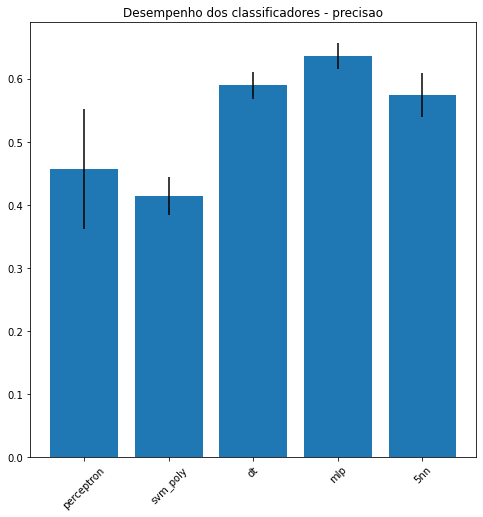

{'clfs': [Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
             fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
             penalty=None, random_state=0, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False),
  SVC(C=36610, break_ties=False, cache_size=500, class_weight=None, coef0=1,
      decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
      max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=366,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='be

In [ ]:
data = pd.DataFrame(np.c_[xPca, y])

classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='precisao',score=precision_score)


Realiza-se mais KFold = 10 para confirmar a qualidade do MLP. 

Além disso verifica-se o desempenho dos classificadores para outros parâmetros de decisão.

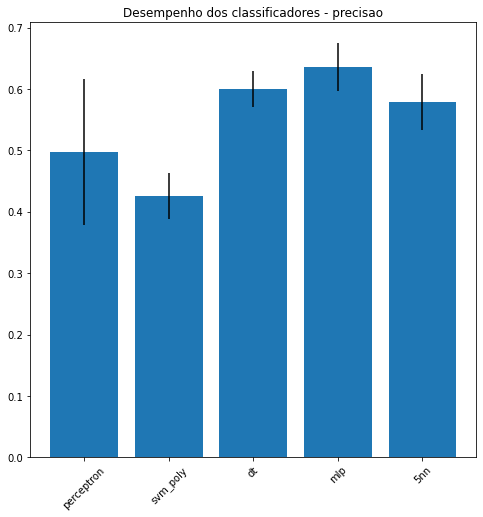

{'clfs': [Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
             fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
             penalty=None, random_state=0, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False),
  SVC(C=36610, break_ties=False, cache_size=500, class_weight=None, coef0=1,
      decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
      max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=366,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='be

In [ ]:
classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='precisao',score=precision_score, folds=10)

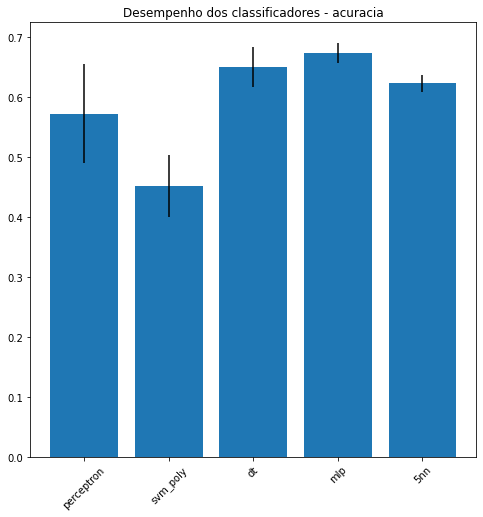

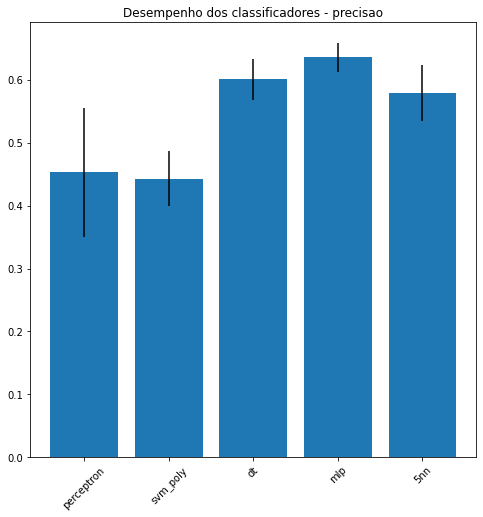

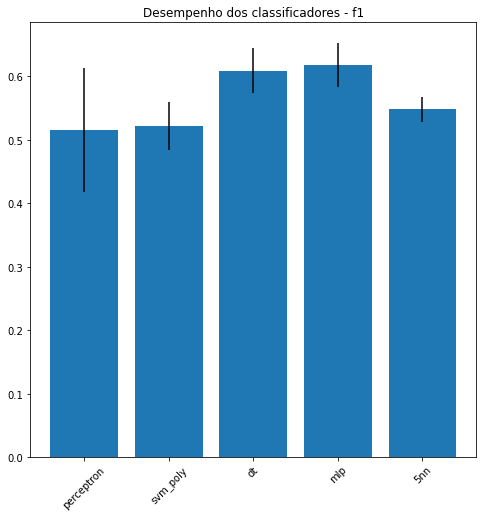

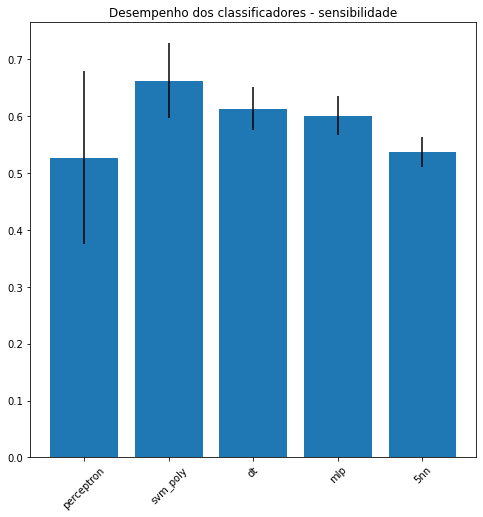

{'clfs': [Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
             fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
             penalty=None, random_state=0, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False),
  SVC(C=36610, break_ties=False, cache_size=500, class_weight=None, coef0=1,
      decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
      max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=366,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='be

In [ ]:
classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='acuracia',score=accuracy_score, folds=10)
classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='precisao',score=precision_score, folds=10)
classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='f1',score=f1_score, folds=10)
classificacao(data, list(range(0,data.shape[1]-1)), data.shape[1]-1, score_name='sensibilidade',score=recall_score, folds=10)

# Curva ROC
Confirma-se o destaque do MLP através do *plot* das curvas ROC dos classificadores

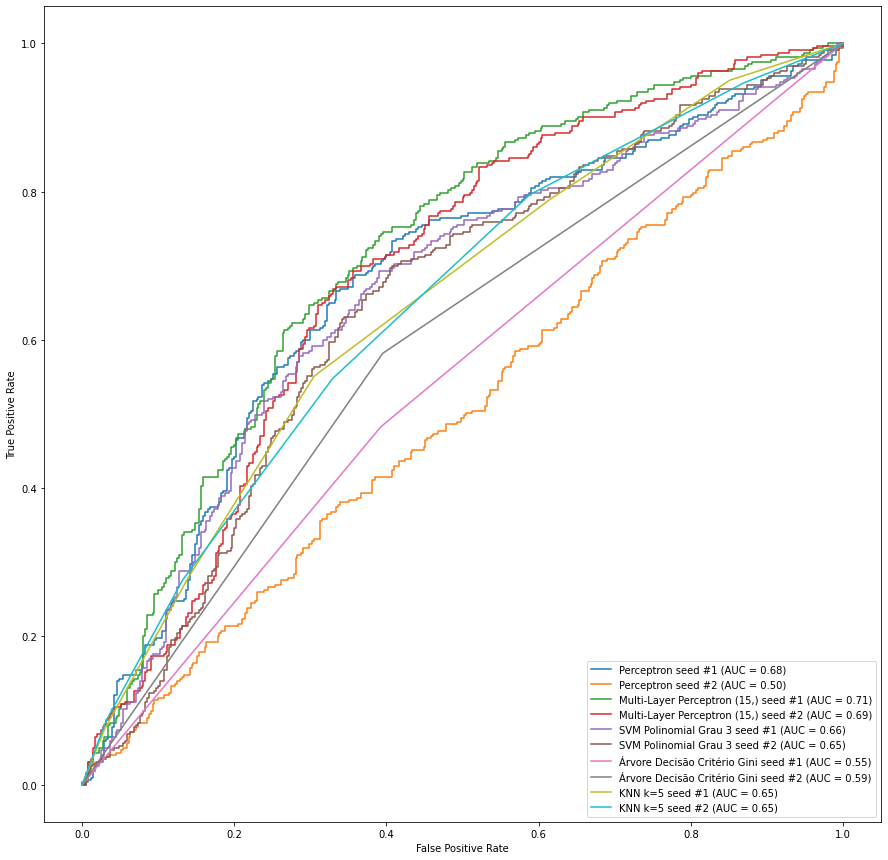

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots()

fig.set_figheight(15)
fig.set_figwidth(15)

seeds = random.sample(range(1,1000000), 2)

for clfName in classificadores:
  clf = classificadores[clfName]['modelo']
  for iSeed,seed in enumerate(seeds):

      X_train, X_teste, y_train, y_teste = train_test_split(xPca, y, train_size=0.8, test_size=0.2,random_state=seed, stratify=y)
      clf.fit(X=X_train, y=y_train)
      plotName = clfName + " seed #" + str(iSeed+1)
      plot_roc_curve(clf, X_teste, y_teste, name=plotName, ax=ax)

Plota-se a curva ROC do Multi-Layer Perception de maneira mais detalhada

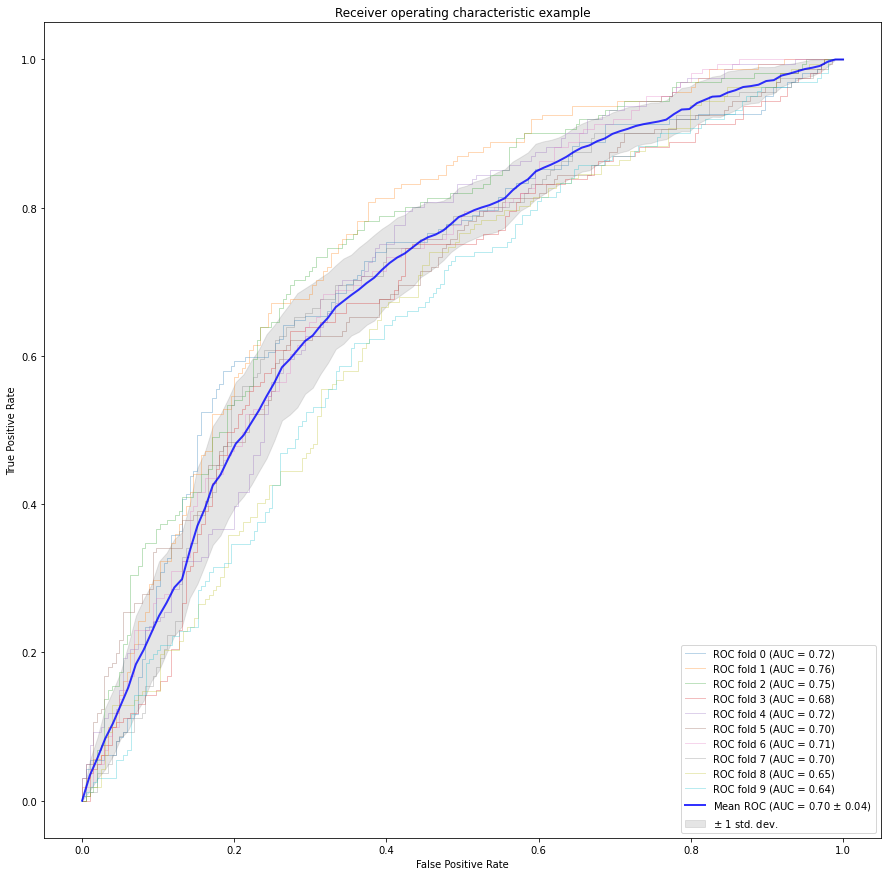

In [ ]:
plot_roc(classificadores['Multi-Layer Perceptron (15,)']['modelo'], xPca, y )